<a href="https://colab.research.google.com/github/facundocarballo/ProgramacionConcurrente/blob/main/TP1/IntegradorM5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Integrador

La idea de este trabajo practico es enlazar todos los conceptos que fuimos viendo a lo largo de la cursada y utilizarlos en conjunto para crear una aplicacion.

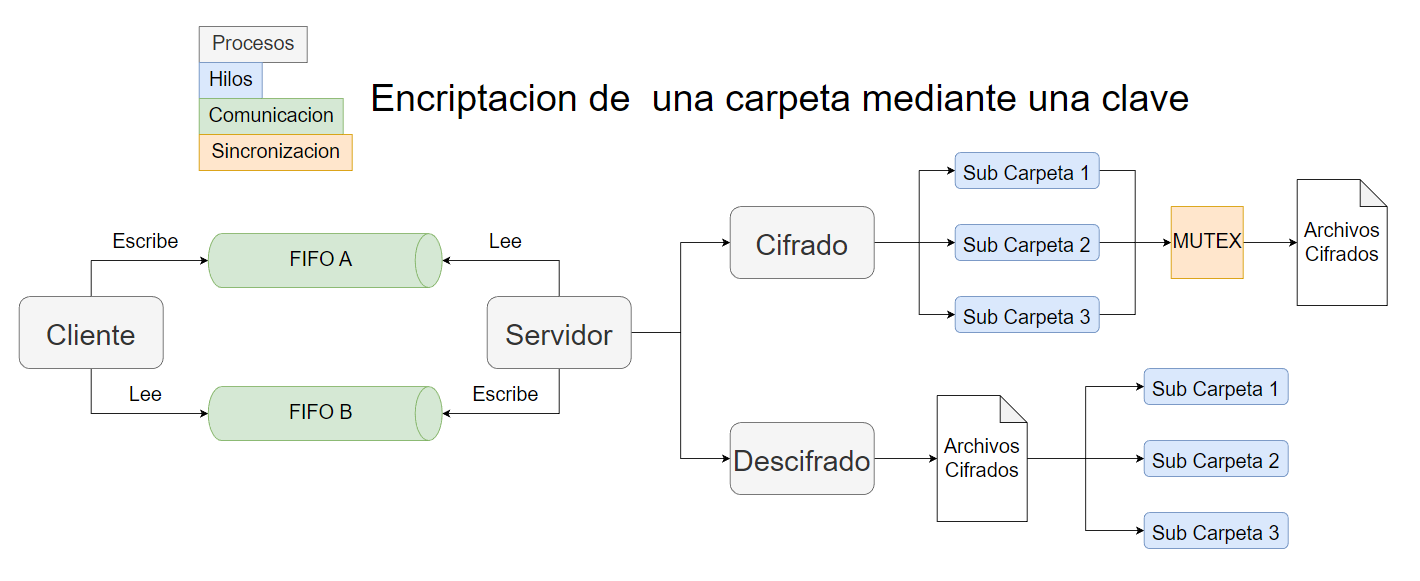

Esta aplicacion busca cifrar y descifrar carpetas con informacion mediante una clave que proporciona el usuario, utilizando el algoritmo de cifrado AES.

Se crea un Servidor que correra en segundo plano, a la espera de que el Cliente le solicite hacer algo.

****
### Mecanismos de Comunicacion
El Cliente y el Servidor se comunican mediante **FIFOs**:
- FIFO A: Cliente escribe y Servidor lee
- FIFO B: Servidor escribe y Cliente lee
****
### Threads
El Servidor lanza un **Hilo** por cada sub carpeta que se encuentra en el directorio que se le envia a cifrar.
****
### Mecanismos de Sincronizacion
El Servidor utiliza un **Mutex** como mecanismo de sincronizacion para poder escribir el archivo cifrado en el orden correcto para asi representar bien la estructura de arbol del Sistema de Archivos.

# Cifrado

Para que el Servidor haga la operacion de cifrado, el Cliente debe ejecutarse de la siguiente manera:



```
python3 ./client -e ./folder key
```

- 🏴 **'-e'** reprensta la bandera para encriptar.
- 📁 **'./folder'** es la carpeta con informacion que se quiere encriptar.
- 🔑 **'key'** es la clave con la cual se encripta esta informacion


El Servidor se encargara de cifrar la informacion de la carpeta y colocara esta informacion cifrada en un archivo llamado **"cipher.enc"**

Es un simple archivo de texto con la informacion necesaria para descifrar estos archivos.

****

**IMPORTANTE**

*La clave no se almacenara en ningun archivo, el usuario debe recordarla.*

****

El archivo cipher.enc se vera de la siguiente forma:

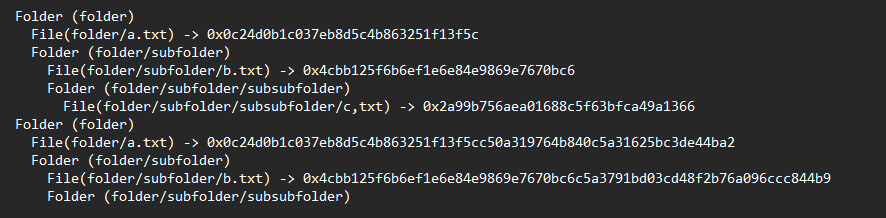

# Descifrado

Para que el Servidor haga la operacion de descifrado, el Cliente debe ejecutarse de la siguiente manera:



```
python3 ./client -d cipher.enc key
```

- 🏴 **'-d'** reprensta la bandera para desencriptar.
- 📁 **'./cipher.enc'** es el archivo con los cifrados.
- 🔑 **'key'** es la clave con la cual se encripto esta informacion

El Servidor se encargara de descifrar la informacion que lea en el archivo **cipher.enc**, volviendo a colocar los archivos en sus ubicaciones correspondientes dentro del Sistema de Archivos.


# Contexto de ejecucion

Para mostrar la ejecucion de esta aplicacion es necesario crear un contexto adecuado para ella.

Vamos a crear carpetas con archivos y sub carpetas, para que puedan ser cifradas y descifradas.

In [1]:
%%shell

mkdir folder

cd folder

touch a.txt
echo "Este es el archivo a.txt" > a.txt

touch b.txt
echo "Este es el archivo b.txt" > b.txt

mkdir subfolder

cd subfolder

touch c.txt
echo "Este es el archivo c.txt" > c.txt

touch d.txt
echo "Este es el archivo d.txt" > d.txt

mkdir subsubfolder

cd subsubfolder

touch e.txt
echo "Este es el archivo e.txt" > e.txt

touch f.txt
echo "Este es el archivo f.txt" > f.txt

mkdir: cannot create directory ‘folder’: File exists
mkdir: cannot create directory ‘subfolder’: File exists
mkdir: cannot create directory ‘subsubfolder’: File exists


Es necesario instalar el modulo **pycryptodome** para poder utilizar el algoritmo de cifrado **AES**

In [2]:
!pip install pycryptodome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Servidor

In [3]:
%%writefile server.py

from Crypto.Cipher import AES
from pathlib import Path
import threading
import os
import sys
import pickle
import signal
import errno
import time

# Bytes
BYTES_16 = 16
BYTES_1024 = 1024

# FIFOs
FIFO_A_PATH = "/tmp/FIFO_A"
FIFO_B_PATH = "/tmp/FIFO_B"
FIFO_A = None
FIFO_B = None
FIFO_PERMISSIONS = 0o600

# Args
ARGV_1 = 1
ARGV_2 = 2
ARGV_3 = 3
ARGV_AMOUNT = 4
ARG_ENCRYPT = "-e"
ARG_DECRYPT = "-d"

# File
FILE_READ_BYTE = "rb"
FILE_READ_TEXT = "r"
FILE_APPEND = "a"
FILE_WRITE_TEXT = "w"
FILE_WRITE_BYTE = "wb"
FILE_START_WITH = "File("
FILE_END_WITH = ")"
FILE_FIND_ERROR = -1

# String
EMPTY_STRING = ""
SPACES_2 = "  "

# Hexa
HEX_START_WITH = "0x"

# Cipher
CIPHER_PATH = './cipher.enc'
IV_KEY = "Concurrencia!!!!".encode('utf-8').ljust(BYTES_16, b'\0')

# Mutex
mutex = threading.Lock()
mutex_folder = threading.Lock()

# Threads
threads = []

# Global Variables
module = None
file_path = None
key = None
obj = None

class Info:
    def __init__(self, module, path, key):
        self.module = module
        self.path = path
        self.key = key

# Signal Managment
def close_server(signal, frame):
    """
    @params:
        [signal]: Is the number of the signal that the process receives.
        [frame]: Information about the stack trace of the process.
    
    @description:
        This function handles the ending of the server.
        Closing all the resources that the Server used.
    """

    # Mark global variables 
    global FIFO_A
    global FIFO_B

    print("Closing server")

    # Close the FIFOs
    if FIFO_A != None:
        os.close(FIFO_A)

    if FIFO_B != None:
        os.close(FIFO_B)

    # Unlink the FIFOs
    os.unlink(FIFO_A_PATH)
    os.unlink(FIFO_B_PATH)

    sys.exit(0)

signal.signal(signal.SIGUSR1, close_server)

# Encrypt and Decrypt Functions
def encrypt_file(key, path, spaces):
    """
    @params:
        key: Is the key that this function use to encript the file.
        path: Is the path to the file that this function will encript.
        spaces: Is the amount of spaces that this function needs to print on the cypher.enc file.
    """
    # Create a cipher obj with AES Algorithm
    cipher = AES.new(key.encode('utf-8', 'ignore'), AES.MODE_CBC, IV_KEY)
    
    # Read the entire file in bytes
    with open(path, FILE_READ_BYTE) as f:
        plaintext = f.read()

    # Add some padding to make it multiple of 16 bytes
    plaintext += b"\0" * (AES.block_size - len(plaintext) % AES.block_size)

    # Cipher the archive using AES on CBC mode
    ciphertext = cipher.encrypt(plaintext)

    # Write in the cipher.enc file the ciphertext with a reference to the original file
    with open(CIPHER_PATH, FILE_APPEND) as f:
        write(spaces + "  File(" + path + ") -> 0x" + str(ciphertext.hex()) + "\n", f)

    # Delete the uncipher file
    os.remove(path)

def encrypt_folder(key, directory, spaces):
    """
    @params:
        key: Is the key that this function use to encript the file.
        directory: Is the directory that this function will encript.
        spaces: Is the amount of spaces that this function needs to print on the cypher.enc file.
    
    @description:
        This function will encript all the files that are include in this folder.
        If this folder contains a sub folder, this function will call himself recursively
        to encript that subfolder too.
    """

    # Request fot the mutext_folder to write the encript file propertly.
    mutex_folder.acquire()

    # Open the encript file and print the name of the folder.
    with open(CIPHER_PATH, FILE_APPEND) as f:
        write(spaces + "Folder (" + str(directory) + ")" + "\n", f)

    # Loop all the files into this folder to encript them.
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isdir(path):
            # If the path is a directory creates a thread to loop that folder and encript the files.
            thread = threading.Thread(
                target=encrypt_folder,
                args=(key, path, spaces + SPACES_2)
            )
            thread.start()
            # Add that thread to our threads array to then join them.
            threads.append(thread)
        else:
            # If the path is a file, just encript the file.
            encrypt_file(key, path, spaces)
    
    # Release the mutex folder for others threads.
    mutex_folder.release()

def decrypt_file(key, ciphertext):
    """
    @params:
        key: Is the key that this function will use to decript the file.
        ciphertext: Is the hex code generetes on the encript file, but in bytes!!!
    """
    cipher = AES.new(key.encode('utf-8', 'ignore'), AES.MODE_CBC, IV_KEY)
    descipher_text = cipher.decrypt(ciphertext)

    return descipher_text.decode('utf-8', 'ignore')

# Write and Read functions
def write(msg, f):
    """
    @params:
        msg: Is the message that this function will write.
        f: Is the file that this function will write.
    """

    # Request the mutext to write the file propertly.
    mutex.acquire()

    f.write(msg)
    
    # Release the mutext.
    mutex.release()

def read_cipher_file(path, key):
    """
    @params:
        path: Is the path of the encripted file.
        key: Is the key to decript the file.

    @description:
        This function will read the encripted file line by line looking for encripted files.
        If the encripted file contains encripted files, would get for those:
            - Director: Directory of that encripted file.
            - Ciphertext: Hex code associate to this file.
            - Plaintext: Plaintext of this encripted file.
        Then, this function will write in the corresponding file, the corresponding plain text
        of the file that was encripted.
    """

    # Open the encripted file
    with open(path, FILE_READ_TEXT) as file:
        # Loop line by line looking for encripted files into it.
        for line in file:
            if (line.find(HEX_START_WITH) != FILE_FIND_ERROR):
                # Get the data of this encripted file
                directory = get_directory(line)
                ciphertext = get_ciphertext(line)
                plaintext = decrypt_file(key, ciphertext)

                # Open the uncripted file to write in it the plaintext
                with open(directory, FILE_WRITE_TEXT) as new_file:
                    new_file.write(plaintext)

# Helpers
def get_directory(line):
    """
    @params:
        line: String that contains the directory.
    """

    spaces = str(line).find(FILE_START_WITH)
    directory_start = len(FILE_START_WITH) + spaces
    directory_end = str(line).find(FILE_END_WITH)
    directory = str(line)[directory_start:directory_end]
    return directory

def get_ciphertext(line):
    """
    @params:
        line: String that contains the ciphertext.
    """

    spaces = str(line).find(HEX_START_WITH)
    directory_start = len(HEX_START_WITH) + spaces
    ciphertext = str(line)[directory_start:len(line)]
    bytes_hex = bytes.fromhex(ciphertext)
    return bytes_hex

# Main functions
def main_encrypt():
    """
    @description:
      This is the main function that handle the files encryption.
    """
    global obj

    # Get the path from the argument.
    path = obj.path

    # Create a 16 bytes key with the key argument.
    key = obj.key.ljust(BYTES_16)[:BYTES_16]

    # Create a Path obj
    directory = Path(path)

    encrypt_folder(key, directory, EMPTY_STRING)
    
    # Join all the threads that were created.
    for thread in threads:
        thread.join()

def main_decrypt():
    """
    @description:
      This is the main function that handles the files decryption.
    """
    # Generate a 16 bytes key
    key = obj.key.ljust(BYTES_16)[:BYTES_16]

    # Get a Path
    directory = Path(obj.path)

    read_cipher_file(directory, key)

    # Delete the cipher file.
    os.remove(CIPHER_PATH)

# FIFOs Functions
def fifo_creates():
    """
    @description:
      This function only try to create the FIFOs to use.
    """
    try:
        os.mkfifo(FIFO_A_PATH, FIFO_PERMISSIONS)
    except OSError as error:
        print("Error creating the FIFO_A: ", error)
    
    try:
        os.mkfifo(FIFO_B_PATH, FIFO_PERMISSIONS)
    except OSError as error:
        print("Error creating the FIFO_B: ", error)
    
def fifos_open():
    """
    @description:
      This function only tries to open the FIFOs.
    """

    # Mark the global variables.
    global FIFO_A 
    global FIFO_B

    try:
        FIFO_A = os.open(FIFO_A_PATH, os.O_RDONLY)
    except OSError as error:
        print("Error opening the FIFO_A: ", error)

    # Is blocked until the client opens his file in READ ONLY
    try:
        FIFO_B = os.open(FIFO_B_PATH, os.O_WRONLY)
    except OSError as error:
        print("Error opening the FIFO_B: ", error)

def fifo_read():
    """
    @description:
      This function only reads the FIFO_A where the client is putting his request.
    """

    # Mark the global variables.
    global obj

    data = os.read(FIFO_A, BYTES_1024)
    if data:
        obj = pickle.loads(data)

def fifo_write(msg):
    """
    @params:
      - [msg]: Is the message that will be writed on the FIFO_B
    
    @description:
      This function only writes a message on the FIFO_B
    """
    
    os.write(FIFO_B, str(msg).encode('utf-8', 'ignore'))

def main():
    """
    @description:
      This is the Server main function.
    """
    
    # Mark global variables
    global obj
    global FIFO_B
    global FIFO_A

    print("Server running with PID: ", os.getpid())

    fifo_creates()
    fifos_open()

    while True:
        # Clear the Object
        obj = None
        
        # Read the FIFO_A
        try:
            fifo_read()
        except OSError as error:
            if error.errno == errno.EAGAIN or error.errno == errno.EWOULDBLOCK:
                # There is not data on FIFO_A
                time.sleep(1)
                continue
            else:
                print("Error reading from FIFO_A: ", error)
                break

        # Check object
        if obj != None and obj.module == ARG_DECRYPT:
            main_decrypt()
            fifo_write("Decryption done.")
        
        if obj != None and obj.module == ARG_ENCRYPT:
            main_encrypt()
            fifo_write("Ecryption done.")



main()

Overwriting server.py


# Cliente

In [4]:
%%writefile client.py
import os
import sys
import pickle

# Bytes
BYTES_16 = 16
BYTES_1024 = 1024

# FIFOs
FIFO_A_PATH = "/tmp/FIFO_A"
FIFO_B_PATH = "/tmp/FIFO_B"
FIFO_A = None
FIFO_B = None
FIFO_PERMISSIONS = 0o600

# Args
ARGV_1 = 1
ARGV_2 = 2
ARGV_3 = 3
ARGV_AMOUNT = 4
ARG_ENCRYPT = "-e"
ARG_DECRYPT = "-d"

class Info:
    def __init__(self, module, path, key):
        self.module = module
        self.path = path
        self.key = key

def help():
    """
    @description:
      This is the Client help function.
    """
    print("HELP")
    print("---------------------------------")
    print("Example of how to execute this program.")
    print("  python3 ./client [module] [path] [key]")
    print("    - [module]:")
    print("      '-e': Encrypting")
    print("      '-d': Decrypting")
    print("    - [path]: Is the path of the folder or file to encrypt or decrypt.")
    print("    - [key]: Is the key to encrypt or decrypt the files.")
    print("---------------------------------")

def main():
    """
    @description:
      This is the Client main function.
    """

    # Check arguments
    if len(sys.argv) != ARGV_AMOUNT:
        help()
        sys.exit(1)

    # Get the module that we want to use (encrypt or decrypt)
    module = sys.argv[ARGV_1]

    # Check the module send by the user
    if module != ARG_DECRYPT and module != ARG_ENCRYPT:
        help()
        sys.exit(1)

    # Get the path from the argument.
    path = sys.argv[ARGV_2]

    # Create a 16 bytes key with the key argument.
    key = sys.argv[ARGV_3].ljust(BYTES_16)[:BYTES_16]

    # Try to open the FIFOs
    try:
        FIFO_A = os.open(FIFO_A_PATH, os.O_WRONLY | os.O_NONBLOCK)
    except OSError as error:
        print("Error opening the FIFO_A: ", error)
    
    try:
        FIFO_B = os.open(FIFO_B_PATH, os.O_RDONLY)
    except OSError as error:
        print("Error opening the FIFO_B: ", error)
    
    obj = Info(module, path, key)

    # Convert the obj to bytes
    obj_bytes = pickle.dumps(obj)

    # Write the obj on the FIFO_A
    os.write(FIFO_A, obj_bytes)

    # aqui

    # Wait for server response
    status = os.read(FIFO_B, BYTES_1024)

    print("Server response: \n  -> " + status.decode('utf-8', 'ignore'))

    # Close FIFOs
    os.close(FIFO_A)
    os.close(FIFO_B)

main()

Overwriting client.py


# Ejecucion

Ejecutamos en segundo plano el Servidor

In [5]:
!nohup python ./server.py 1> server.log 2> server.error < /dev/null &

Garantizamos que el servidor este corriendo en segundo plano.

In [6]:
!ps aux | grep server.py

root        8477  0.0  0.0  17040  9476 ?        R    11:03   0:00 python3 ./server.py
root        8479  0.0  0.0   6904  3356 ?        S    11:03   0:00 /bin/bash -c ps aux | grep server.py
root        8481  0.0  0.0   1128   316 ?        R    11:03   0:00 grep server.py


Ejecutamos el Cliente.

Primero, cifraremos la informacion contenida en la carpeta **folder**

Visualizamos el contenido de esta carpeta.

In [7]:
%%shell
cd folder
ls

a.txt  b.txt  subfolder


Ejecutamos la encriptacion.

In [8]:
!python3 ./client.py -e ./folder key

Server response: 
  -> Ecryption done.


Verificamos que se hayan eliminado los archivos de texto.

In [9]:
%%shell
cd folder
ls

subfolder


Visualizamos el contenido del archivo cifrado. **cipher.enc**

In [10]:
!cat ./cipher.enc

Folder (folder)
  File(folder/b.txt) -> 0x34a9fcd1359d453c3e7948580a53b6972a0e1a1924175803a4a6e650b06365dc
  File(folder/a.txt) -> 0x34a9fcd1359d453c3e7948580a53b697c62e357f38c01522dc21b3f5d474bb9b
  Folder (folder/subfolder)
    File(folder/subfolder/c.txt) -> 0x34a9fcd1359d453c3e7948580a53b6975eab2bc63157aff372b2b801e8c741e5
    File(folder/subfolder/d.txt) -> 0x34a9fcd1359d453c3e7948580a53b6978fe174d2459d877c2b0f090ea97cb722
    Folder (folder/subfolder/subsubfolder)
      File(folder/subfolder/subsubfolder/f.txt) -> 0x34a9fcd1359d453c3e7948580a53b697658ebb091c12115a7f6acf5064d5bcb9
      File(folder/subfolder/subsubfolder/e.txt) -> 0x34a9fcd1359d453c3e7948580a53b697a7d2884dd408f8633e6bf16edb378fda


Ejecutamos la desencriptacion.

In [11]:
!python3 ./client.py -d ./cipher.enc key

Server response: 
  -> Decryption done.


Verificamos que los archivos de texto hayan vuelto a sus carpetas correspondientes.



In [12]:
%%shell
cd folder
ls

a.txt  b.txt  subfolder


Matamos al Servidor

Primero buscamos su PID

In [13]:
!ps aux | grep server.py

root        8477 71.0  0.1 171596 17096 ?        R    11:03   0:00 python3 ./server.py
root        8494  0.0  0.0   6904  3228 ?        S    11:03   0:00 /bin/bash -c ps aux | grep server.py
root        8496  0.0  0.0   6448   716 ?        S    11:03   0:00 grep server.py


Luego le mandamos la senal KILL para que finalice su ejecucion

In [16]:
!kill -SIGUSR1 8477

Verificamos que lo matamos correctamente.

In [17]:
!ps aux | grep server.py

root        8672  0.0  0.0   6904  3184 ?        S    11:04   0:00 /bin/bash -c ps aux | grep server.py
root        8674  0.0  0.0   6448   656 ?        S    11:04   0:00 grep server.py
